<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Packages

In [1]:
# restart runtime after running and skip this cell
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 3.5 MB/s eta 0:00:00


##2. Import Packages

In [1]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm

##3. Create Simple RL Model

In [2]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [3]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

In [4]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials),dtype=np.int32)
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

##4. Simulate Model

In [5]:
seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
n_trials = 1000
temperature = 0.8
alpha = 0.1

In [6]:
rl_model = SimpleRL(n_trials=n_trials, distributions=dists)
rewards, choices = rl_model.simulate(alpha,temperature)
qs = rl_model.q_trace

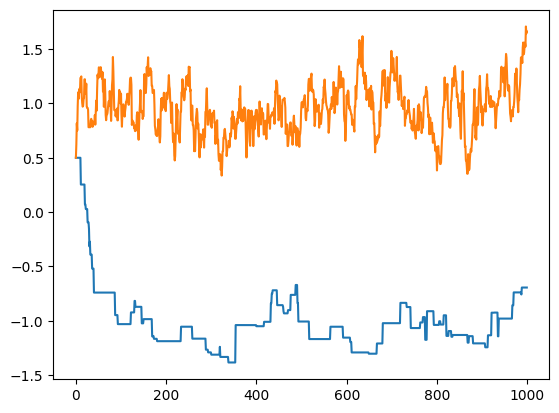

In [7]:
# plotting q values
plt.plot(qs)

##5. Create Loglikelihood Function in PyTensor

###5a. Simulate RL

In [8]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty matrix to store q-values across trials
a = pt.scalar("a") # learning rate

# function for a single RL step
def rl_step(c, r, q_tm1):
  m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
  rm = r * m
  qm = q_tm1 * m
  return q_tm1 + a * (rm - qm)

# scan function build
Qs, updates = pytensor.scan(rl_step, sequences=[C,R], outputs_info=Q)

# Q Prediction function compilation
q_predict = pytensor.function(inputs=[C, R, Q, a], outputs=Qs)

# test values
C_test = np.random.choice(2, size = (100,)).astype(np.int32)
R_test = np.ones((100,), dtype=np.float32)
Q_test = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
a_test = 0.1

# RL Model function test
q_predict(C_test,R_test,Q_test,a_test)

array([[0.1       , 0.        ],
       [0.1       , 0.1       ],
       [0.1       , 0.19      ],
       [0.19      , 0.19      ],
       [0.19      , 0.271     ],
       [0.19      , 0.3439    ],
       [0.271     , 0.3439    ],
       [0.271     , 0.40951   ],
       [0.271     , 0.468559  ],
       [0.3439    , 0.468559  ],
       [0.40951   , 0.468559  ],
       [0.40951   , 0.5217031 ],
       [0.468559  , 0.5217031 ],
       [0.5217031 , 0.5217031 ],
       [0.56953279, 0.5217031 ],
       [0.61257951, 0.5217031 ],
       [0.65132156, 0.5217031 ],
       [0.6861894 , 0.5217031 ],
       [0.6861894 , 0.56953279],
       [0.6861894 , 0.61257951],
       [0.71757046, 0.61257951],
       [0.74581342, 0.61257951],
       [0.74581342, 0.65132156],
       [0.77123208, 0.65132156],
       [0.77123208, 0.6861894 ],
       [0.79410887, 0.6861894 ],
       [0.79410887, 0.71757046],
       [0.81469798, 0.71757046],
       [0.83322818, 0.71757046],
       [0.84990536, 0.71757046],
       [0.

###5b. Calculate Loglikelihood of Simulation given parameters

In [9]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, a, b, ll)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

array([-0.79813887, -0.59813887, -0.59813887, -0.90108961, -0.52108961,
       -0.52108961, -0.52108961, -0.52108961, -0.52108961, -0.52108961,
       -0.52108961, -1.00042683, -1.09505068, -0.40725068, -1.18426258,
       -1.26768372, -1.34517814, -1.41678671, -1.48267385, -0.25751482,
       -1.5430861 , -0.24044298, -0.24044298, -1.598321  , -1.64870418,
       -0.21356325, -0.21356325, -0.21356325, -0.21356325, -1.69457283,
       -0.20294599, -1.73626415, -0.1938    , -1.77410741, -0.18588967,
       -0.18588967, -1.80841872, -0.17902275, -0.17902275, -1.83949777,
       -1.867626  , -0.16781527, -1.89306575, -0.16323609, -0.16323609,
       -0.16323609, -0.16323609, -0.16323609, -1.91606016, -0.15921347,
       -1.93683352, -0.15567149, -0.15567149, -0.15567149, -0.15567149,
       -1.95559194, -0.15254612, -1.97252429, -1.98780313, -0.14733602,
       -0.14733602, -2.00158587, -0.14516547, -2.01401578, -0.14323741,
       -2.02522308, -2.03532601, -2.04443179, -2.05263755, -2.06

##6. Calculate Likelihoods

##7. PyMC Likelihood Modelling

Wrapping model into PyMC using pm potential

Code was taken from PyMC documentation and modified

In [10]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dvector]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, c, r):
        # add inputs as class attributes
        self.likelihood = loglike
        self.C = c
        self.R = r

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      outputs[0][0] = self.likelihood(theta[0], theta[1])



/usr/local/lib/python3.10/dist-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:13.505717
Sampling...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Sampling time =  0:00:08.099143
Transforming variables...
Transformation time =  0:00:00.073936


/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'m', 'c'} expected from {'a', 'b'}
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


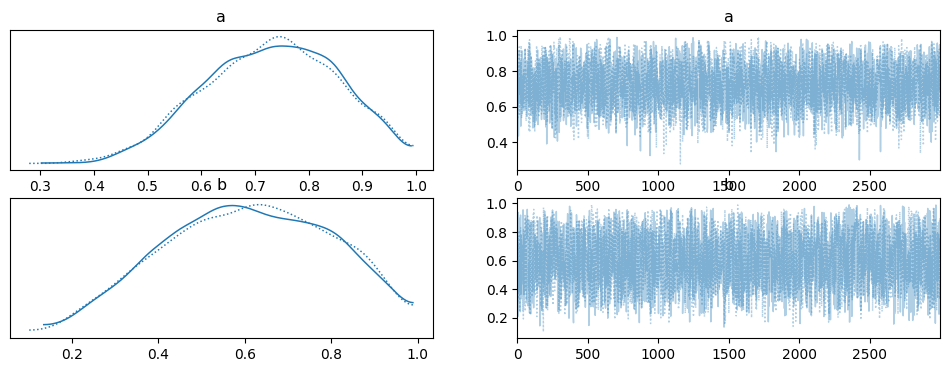

In [11]:
# Creating Ground Truth Data
n_trials = 250
mean_rewards = [-0.5,0.5]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":0.2}) for mn in mean_rewards]
rl_model = SimpleRL(n_trials=n_trials,distributions=dists)

a_true = 0.8
b_true = 0.5
R_true, C_true = rl_model.simulate(a_true,b_true)
Qs_true = np.ones((2,)) * 0.5
ll_true = 0

# use PyMC to sampler from log-likelihood
with pm.Model():
    # Data
    C = pm.ConstantData('myC', C_true)
    R = pm.ConstantData('myR', R_true)
    Q = pm.ConstantData("myQ", Qs_true)
    ll_true = pm.ConstantData('ll_true', ll_true)

    # Priors
    a = pm.Beta(name="a",alpha=2,beta=2)
    b = pm.Beta(name="b",alpha=2,beta=2)
    # a = pm.LogNormal(name="a", sigma=1.0)
    # b = pm.LogNormal(name="b", sigma=2.0)

    # convert m and c to a tensor vector

    # rl_likelihoods = pm.RLModel("name", *params, observed = (C, R))

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_ll_func(C, R, Q, a, b, ll_true))
    #pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

# plot the traces
az.plot_trace(idata_mh, lines=[("m", {}, a_true), ("c", {}, b_true)]);

<Axes: xlabel='a', ylabel='b'>

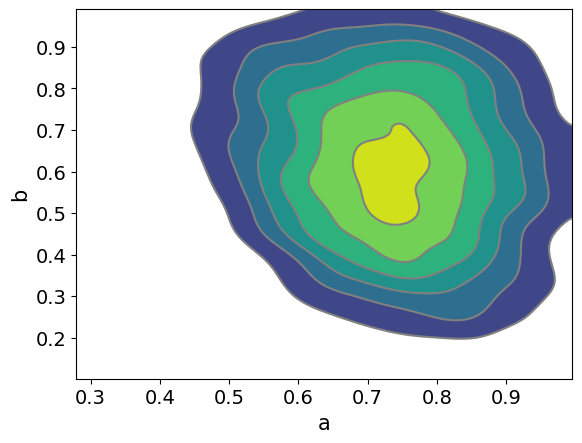

In [12]:
az.plot_pair(idata_mh, kind="kde")

##8. Model Calibration

In [72]:
def fit_pymc(R,C,priors):
  # create our Op
  logl = LogLike(loglike_func, R, C)
  # use PyMC to sampler from log-likelihood
  with pm.Model():
      # uniform priors on m and c
      prior_dists, prior_args = priors
      a = prior_dists[0](*prior_args[0])
      b = prior_dists[1](*prior_args[1])
      # convert m and c to a tensor vector
      theta = pt.as_tensor_variable([a, b])
      # use a Potential to "call" the Op and include it in the logp computation
      pm.Potential("likelihood", logl(theta))
      # Use custom number of draws to replace the HMC based defaults
      idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")
  return idata_mh

In [73]:
# Calibration Parameters
nrep = 10
trials = 500
a_range = (0.01,0.99)
b_range = (0.01,0.99)
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
prior_dist = (pm.Uniform, pm.Uniform)
prior_args = (["a", 1e-4, 1e-0],
              ["b", 1e-4, 1e+0])  # alpha=1, beta=1; alpha=10 beta=10
priors = (prior_dist, prior_args)
# Calibrator Functions
def sample(n_trials,dists,a,b):
  return SimpleRL(n_trials=n_trials,distributions=dists).simulate(alpha=a,temperature=b)

In [ ]:
# quantiles = np.zeros((nrep,2))
# for rep_i in tqdm(range(nrep)):
#   a_true = np.random.uniform(*a_range)
#   b_true = np.random.uniform(*b_range)
#   y_R, y_C = sample(trials,dists,a_true,b_true)
#   data = fit_pymc(y_R, y_C, priors)
#   quantiles[rep_i,0] = np.mean(data.posterior.a > a_true)
#   quantiles[rep_i,1] = np.mean(data.posterior.b > b_true)
#   az.plot_trace(data, lines=[("m", {}, a_true), ("c", {}, b_true)])

In [ ]:
# plt.hist(quantiles[:,0])
# plt.show()
# plt.hist(quantiles[:,1])
# plt.show()
# quantiles

##9. Hierarchical Bayes for Reinforcment Learning

Create Multi-participant RL data

In [74]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)


In [75]:
multi_rl_model = MultiRL(n_trials=50,n_participants=5,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)
data.shape

(250, 4)

Create Hierarchical Model - update for RL

###9b. Hierarchical Loglikelihood Function

In [ ]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_mll_func(C, R, Q, a, b, ll)
  def my_ll_func(C, R, Q, a, b, ll):


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, a, b, ll)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

In [100]:
# define a pytensor Op for our likelihood function
class MultiLogLike(pt.Op):

    itypes = [pt.dmatrix]  # expects a matrix of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, r, c, ids, n_ids, n_trials):
        # add inputs as class attributes
        self.likelihood = loglike
        self.R = r
        self.C = c
        self.ids = ids
        self.n_ids = n_ids
        self.n_trials = n_trials

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      total = 0
      # total = np.zeros((len(self.ids.unique())))
      # for i, id in enumerate(self.unique_ids):
      #  id_index = self.ids[self.ids == id]
      for i in range(self.n_ids):
        r = self.R[i*self.n_trials:(i+1)*self.n_trials]
        c = self.C[i*self.n_trials:(i+1)*self.n_trials]
        a = theta[0][i]
        b = theta[1][i]
        total += self.likelihood(a,b, r, c)
      outputs[0][0] = np.array(total)

In [101]:
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

In [102]:
# set up our data
ll_true = 0
Qs_true = np.ones((2,)) * 0.5
R_true = df['Rewards']
C_true = df['Choices']
ids = df['Participant_ID']
n_ids = len(ids.unique())
n_trials = len(R_true)//n_ids

with pm.Model(coords=coords) as hierarchical_model:
    # Data
    C = pm.ConstantData('myC', C_true)
    R = pm.ConstantData('myR', R_true)
    Q = pm.ConstantData("myQ", Qs_true)
    ll_true = pm.ConstantData('ll_true', ll_true)
    IDs = pm.ConstantData("myIDs", ids)

    mlogl = MultiLogLike(my_ll_func,R,C,IDs,n_ids,n_trials)

    # Hyperpriors for group nodes
    alpha_a = pm.HalfNormal(name="alpha_a", sigma=1.0)
    beta_a = pm.HalfNormal(name="beta_a", sigma=1.0)
    alpha_b = pm.HalfNormal(name="alpha_b", sigma=1.0)
    beta_b = pm.HalfNormal(name="beta_b", sigma=1.0)

    # Intercept for each participant, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_participants).
    a = pm.Beta(name="a",alpha=alpha_a,beta=beta_a,dims="Participant")
    b = pm.Beta(name="b",alpha=alpha_b,beta=beta_b,dims="Participant")

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([a, b])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", mlogl(theta))
    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="pymc")

TypeError: ignored

In [ ]:
az.plot_trace(idata_mh);  # real and assumed disributions differed ; limited parameter values

In [ ]:
az.rcParams['plot.max_subplots'] = 100
az.plot_pair(idata_mh, kind="kde")

In [ ]:
az.plot_trace(idata_mh);  # bad beta values